## Data Exploration

In [1]:
import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit as masking
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

np.set_printoptions(threshold=np.inf)
%matplotlib inline

In [2]:
with open("data/musae_git_features.json") as json_data:
    data_raw = json.load(json_data)

edges=pd.read_csv("data/musae_git_edges.csv")
target_df=pd.read_csv("data/musae_git_target.csv")#.to_numpy()[:,2]

In [3]:
feats=[]
feat_counts=[]
for i in range(len(data_raw)):
    feat_counts+=[len(data_raw[str(i)])]
    feats+=data_raw[str(i)]
    
print("5 top nodes")
print(target_df.head(5).to_markdown())
print()
print("5 last nodes")
print(target_df.tail(5).to_markdown())
print()
print("5 top edges")
print(edges.head(5).to_markdown())
print()
print("5 last edges")
print(edges.tail(5).to_markdown())

5 top nodes
|    |   id | name         |   ml_target |
|---:|-----:|:-------------|------------:|
|  0 |    0 | Eiryyy       |           0 |
|  1 |    1 | shawflying   |           0 |
|  2 |    2 | JpMCarrilho  |           1 |
|  3 |    3 | SuhwanCha    |           0 |
|  4 |    4 | sunilangadi2 |           1 |

5 last nodes
|       |    id | name           |   ml_target |
|------:|------:|:---------------|------------:|
| 37695 | 37695 | shawnwanderson |           1 |
| 37696 | 37696 | kris-ipeh      |           0 |
| 37697 | 37697 | qpautrat       |           0 |
| 37698 | 37698 | Injabie3       |           1 |
| 37699 | 37699 | caseycavanagh  |           0 |

5 top edges
|    |   id_1 |   id_2 |
|---:|-------:|-------:|
|  0 |      0 |  23977 |
|  1 |      1 |  34526 |
|  2 |      1 |   2370 |
|  3 |      1 |  14683 |
|  4 |      1 |  29982 |

5 last edges
|        |   id_1 |   id_2 |
|-------:|-------:|-------:|
| 288998 |  37527 |  37596 |
| 288999 |  37529 |  37601 |
| 289000 |  

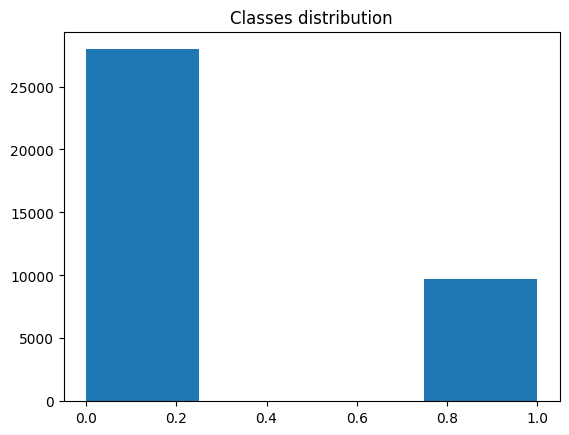

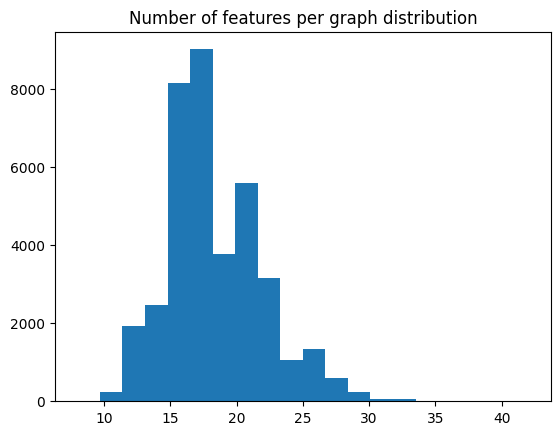

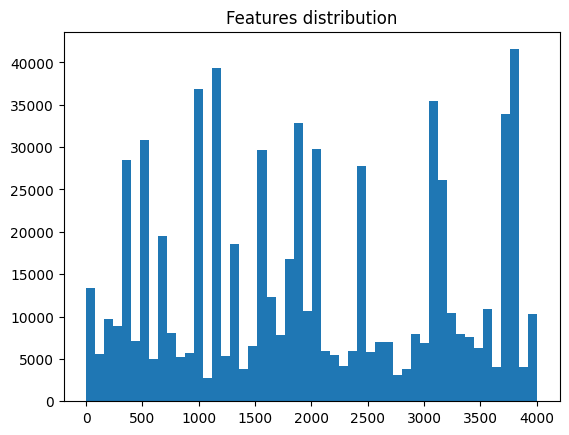

In [4]:
plt.hist(target_df.ml_target,bins=4,);
plt.title("Classes distribution")
plt.show()

plt.hist(feat_counts,bins=20)
plt.title("Number of features per graph distribution")
plt.show()

plt.hist(feats,bins=50)
plt.title("Features distribution")
plt.show()

In [5]:
dict(list(data_raw.items())[:2])

{'0': [1574,
  3773,
  3571,
  2672,
  2478,
  2534,
  3129,
  3077,
  1171,
  2045,
  1539,
  902,
  1532,
  2472,
  1122,
  2480,
  3098,
  2115,
  1578],
 '1': [1193,
  376,
  73,
  290,
  3129,
  1852,
  3077,
  1171,
  1022,
  2045,
  536,
  2040,
  1533,
  1532,
  2472,
  673,
  798]}

In [6]:
feats[:10], feat_counts[:10]

([1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045],
 [19, 17, 19, 15, 19, 26, 14, 14, 15, 16])

In [7]:
len(feats), len(feat_counts)

(690374, 37700)

In [8]:
counter=collections.Counter(feats)
print(list(counter.keys())[:10])
print(list(counter.values())[:10])
print(list(counter.keys())[-10:])
print(list(counter.values())[-10:])

[1574, 3773, 3571, 2672, 2478, 2534, 3129, 3077, 1171, 2045]
[5045, 12726, 2486, 298, 165, 510, 22075, 28188, 24958, 21449]
[936, 172, 875, 3548, 2745, 793, 1941, 464, 2616, 3124]
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1]


In [9]:
def encode_data(light=False,n=60):
    if light==True:
        nodes_included=n
    elif light==False:
        nodes_included=len(data_raw)
    
    data_encoded={}
    for i in range(nodes_included):
        one_hot_feat=np.array([0]*(max(feats)+1))
        this_feat=data_raw[str(i)]
        one_hot_feat[this_feat]=1
        data_encoded[str(i)]=list(one_hot_feat)
    
    if light==True:
        sparse_feat_matrix=np.zeros((1,max(feats)+1))
        for j in range(nodes_included):
            temp=np.array(data_encoded[str(j)]).reshape(1,-1)
            sparse_feat_matrix=np.concatenate((sparse_feat_matrix,temp),axis=0)
        sparse_feat_matrix=sparse_feat_matrix[1:,:]
        return(data_encoded,sparse_feat_matrix)
    elif light==False:
        return(data_encoded, None)

data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)

print(type(data_encoded_vis), len(data_encoded_vis), len(data_encoded_vis['0']))
print(type(sparse_feat_matrix_vis), sparse_feat_matrix_vis.shape, len(sparse_feat_matrix_vis[0]))

<class 'dict'> 60 4005
<class 'numpy.ndarray'> (60, 4005) 4005


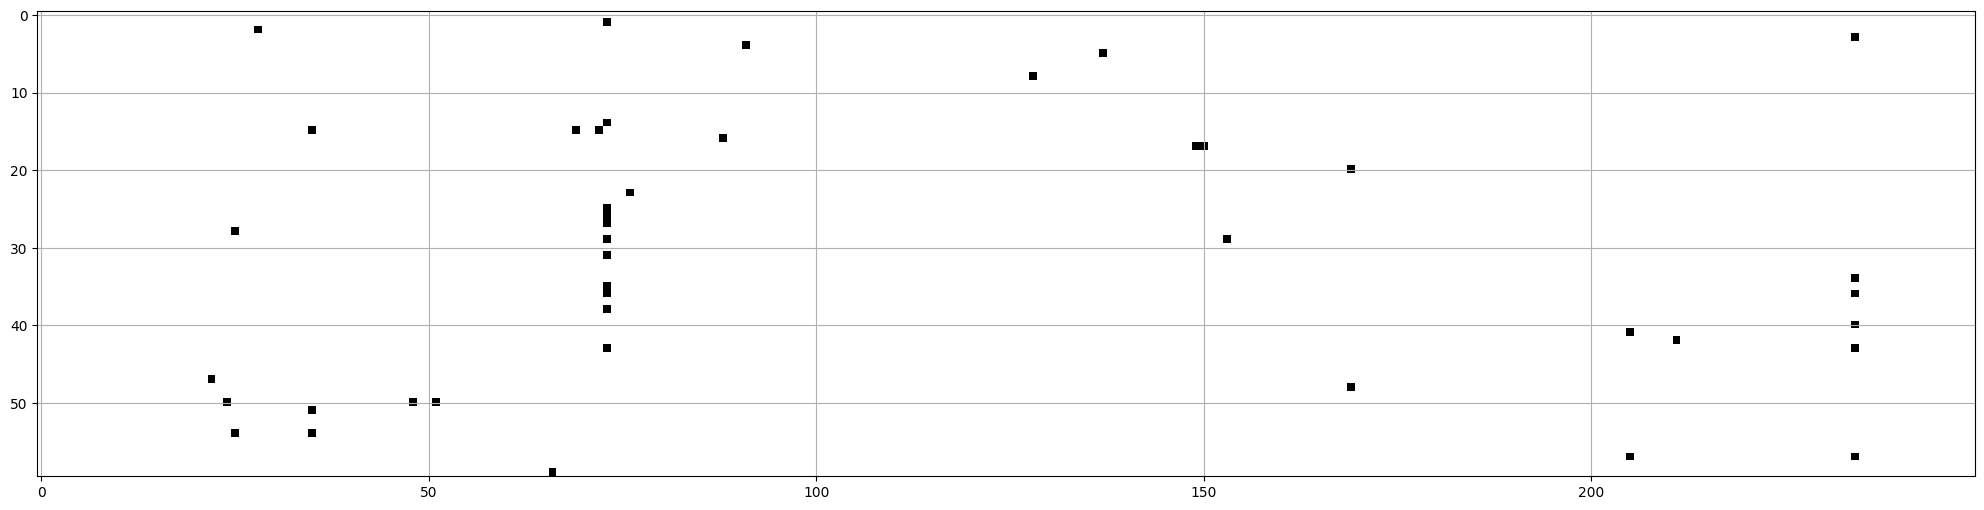

In [10]:
data_encoded_vis,sparse_feat_matrix_vis=encode_data(light=True,n=60)
plt.figure(figsize=(25,25));
plt.imshow(sparse_feat_matrix_vis[:,:250],cmap='Greys')
plt.grid()

In [11]:
def construct_graph(data_encoded,light=False):
    node_features_list = list(data_encoded.values()) # [[], [], [], ..., []] (nodes, features) (60, 4005)
    node_features = torch.tensor(node_features_list) # (nodes, features) (60, 4005)
    node_labels = torch.tensor(target_df['ml_target'].values) # (nodes,) (0/1) (37700,)
    
    edges_direct = torch.tensor(edges.values.tolist(), dtype = torch.long).T # (2, 289003) [Node_Num, Node_Num]
    
    edges_reverse = torch.zeros(edges_direct.shape, dtype = torch.long) # (2, 289003) [0, 0]
    edges_reverse[0,:] = edges_direct[1,:] # (2, 289003) [Node_Num, 0]
    edges_reverse[1,:] = edges_direct[0,:] # (2, 289003) [Node_Num, Node_Num]
    
    edge_indices = torch.cat((edges_direct,edges_reverse),axis=1) # (2, 578006(289003 * 2)) [Node_Num, Node_Num]
    
    if light:
        #                      (60, 2)                   (37700)                   (2, 55)
        graph_light = Data(x = node_features[:,0:2], y = node_labels, edge_index = edge_indices[:,:55])
        return(graph_light)
    else:
        #                (37700, 4005)      (37700)                   (2, 578006)
        graph = Data(x = node_features, y = node_labels, edge_index = edge_indices)
        return(graph)

In [12]:
def draw_graph(graph):
    if graph.num_nodes>100:
        print("This is a big graph, can not plot...")
    else:
        network = to_networkx(graph)
        node_colors = graph.y[list(network.nodes)]
        pos = nx.spring_layout(network,scale = 1)
        
        plt.figure(figsize=(12,8))
        nx.draw(network,
                pos,
                cmap = plt.get_cmap('Set1'),
                node_color = node_colors,
                node_size = 600,
                connectionstyle = "angle3",
                width = 1,
                with_labels = False,
                edge_color = 'k',
                arrowstyle = "-")

Data(x=[60, 2], edge_index=[2, 55], y=[37700])


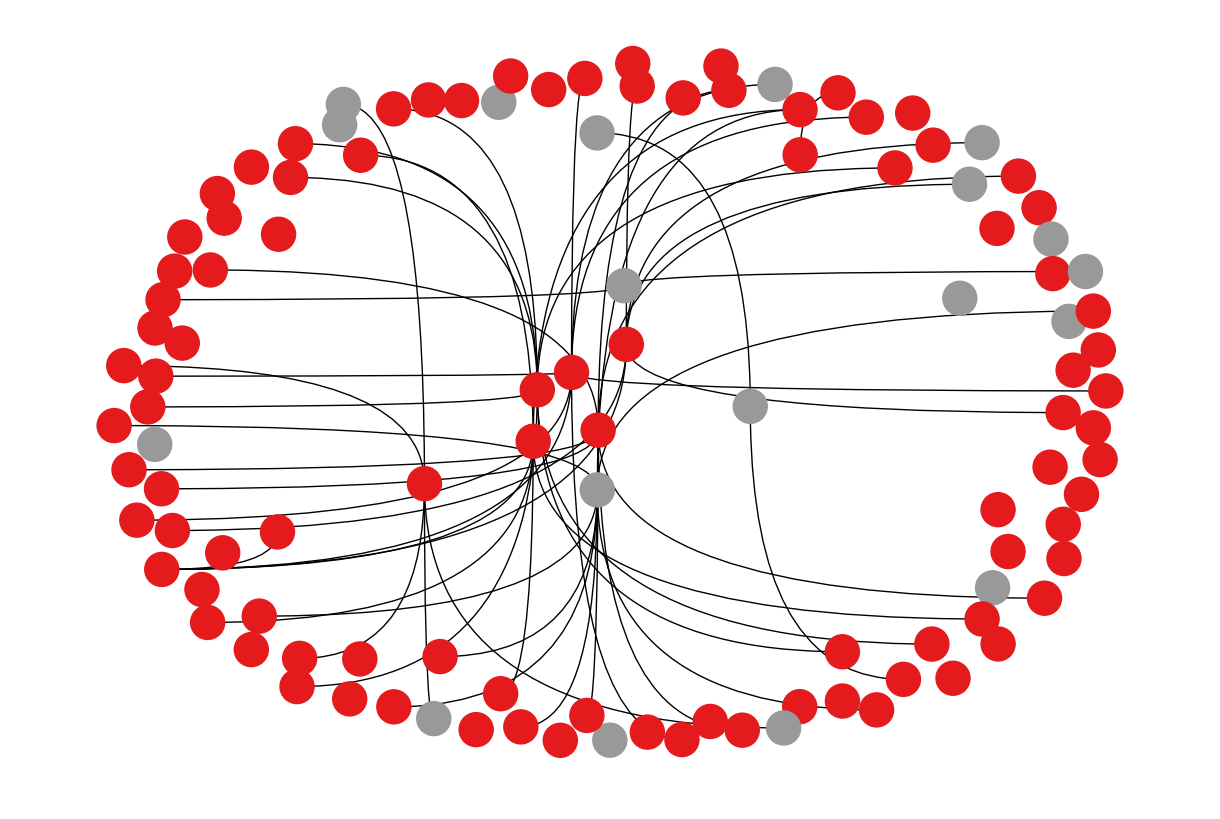

In [13]:
graph = construct_graph(data_encoded = data_encoded_vis, light = True)
print(graph)
draw_graph(graph)

In [14]:
data_nx = to_networkx(graph)
print(data_nx.edges, end='\n\n')
print(data_nx.nodes)

[(0, 23977), (1, 34526), (1, 2370), (1, 14683), (1, 29982), (1, 21142), (1, 20363), (1, 23830), (1, 34035), (3, 4950), (3, 18029), (3, 3358), (3, 34935), (3, 5916), (4, 2865), (4, 9342), (5, 27803), (6, 27803), (6, 18612), (6, 18876), (6, 31890), (6, 17647), (6, 18562), (7, 37493), (7, 33643), (7, 30199), (7, 35773), (7, 11273), (7, 12775), (7, 21864), (7, 9051), (8, 19253), (8, 27803), (8, 11083), (8, 23973), (8, 36652), (8, 10080), (8, 14003), (8, 4793), (9, 15477), (9, 23914), (9, 27803), (9, 33129), (9, 27768), (9, 19407), (6067, 19720), (6067, 20183), (34957, 21395), (34957, 9891), (34957, 9340), (34957, 31260), (34957, 14820), (34957, 31890), (34957, 26666), (34957, 22516)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 23977, 34526, 2370, 14683, 29982, 21142, 20363, 23830, 34035, 6067, 19720, 2018

## Model

In [15]:
data_encoded, _ = encode_data(light=False)

In [16]:
graph = construct_graph(data_encoded=data_encoded,light=False)

In [17]:
graph.x.shape

torch.Size([37700, 4005])

In [18]:
msk = masking(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.6)
mask = msk(graph)

print(mask, end = '\n\n')

print("training samples:", torch.sum(mask.train_mask).item())
print("validation samples:", torch.sum(mask.val_mask).item())
print("test samples:", torch.sum(mask.test_mask).item())

Data(x=[37700, 4005], edge_index=[2, 578006], y=[37700], train_mask=[37700], val_mask=[37700], test_mask=[37700])

training samples: 3770
validation samples: 11310
test samples: 22620


In [19]:
class SocialGNN(torch.nn.Module):
    def __init__(self, num_of_feat, f):
        super(SocialGNN, self).__init__()

        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)


    def forward(self, data):
        x = data.x.float()          
        x = self.conv1(x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        
        return x

In [20]:
def masked_loss(predictions, labels, mask):
    mask = mask.float()

    criterion = nn.CrossEntropyLoss(reduction='none')

    loss = criterion(predictions, labels)
    
    loss = loss * mask

    return loss.sum() / mask.sum()

In [21]:
def masked_accuracy(predictions, labels, mask):
    
    mask = mask.float()
    mask = mask / torch.mean(mask)
    
    accuracy = (torch.argmax(predictions,axis=1)==labels).long()
    accuracy = mask*accuracy
    accuracy = torch.mean(accuracy)

    return (accuracy)    

In [22]:
def train_social(net, data, epochs=10, lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    
    train_losses=[]
    train_accuracies=[]

    val_losses=[]
    val_accuracies=[]

    test_losses=[]
    test_accuracies=[]
    
    for ep in range(epochs):
        
        optimizer.zero_grad()
        out = net(data)

        #                  (37700, 2)       (37700,)       (37700,)
        loss = masked_loss(predictions=out, labels=data.y, mask=data.train_mask) 
        loss.backward()

        optimizer.step()
        
        # ---------------- train ---------------------
        # loss already calculated
        train_losses.append(loss.detach().item())

        train_accuracy = masked_accuracy(predictions=out, labels=data.y, mask=data.train_mask)
        train_accuracies.append(train_accuracy.detach().item())
        
        # ---------------- validation ----------------
        val_loss = masked_loss(predictions=out, labels=data.y, mask=data.val_mask)
        val_losses.append(val_loss.detach().item())
        
        val_accuracy = masked_accuracy(predictions=out, labels=data.y, mask=data.val_mask)
        val_accuracies.append(val_accuracy.detach().item())

        # ---------------- testing -------------------
        test_loss = masked_loss(predictions=out, labels=data.y, mask=data.test_mask)
        test_losses.append(test_loss.detach().item())
        
        test_accuracy = masked_accuracy(predictions=out, labels=data.y, mask=data.test_mask)
        test_accuracies.append(test_accuracy.detach().item())


        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
                      .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            best_accuracy=val_accuracy

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.plot(test_losses, label="Test Loss")  
    plt.legend()
    plt.show()
    
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy") 
    plt.legend()
    plt.show()

Epoch 1/25, Train_Loss: 0.7019, Train_Accuracy: 0.2660, Val_Accuracy: 0.2595, Test_Accuracy: 0.2604
Epoch 2/25, Train_Loss: 0.7851, Train_Accuracy: 0.7350, Val_Accuracy: 0.7427, Test_Accuracy: 0.7423
Epoch 3/25, Train_Loss: 0.4927, Train_Accuracy: 0.7355, Val_Accuracy: 0.7431, Test_Accuracy: 0.7427
Epoch 4/25, Train_Loss: 0.5178, Train_Accuracy: 0.7456, Val_Accuracy: 0.7506, Test_Accuracy: 0.7499
Epoch 5/25, Train_Loss: 0.4874, Train_Accuracy: 0.8175, Val_Accuracy: 0.8220, Test_Accuracy: 0.8200
Epoch 6/25, Train_Loss: 0.4282, Train_Accuracy: 0.8642, Val_Accuracy: 0.8571, Test_Accuracy: 0.8611
Epoch 7/25, Train_Loss: 0.3811, Train_Accuracy: 0.8724, Val_Accuracy: 0.8613, Test_Accuracy: 0.8640


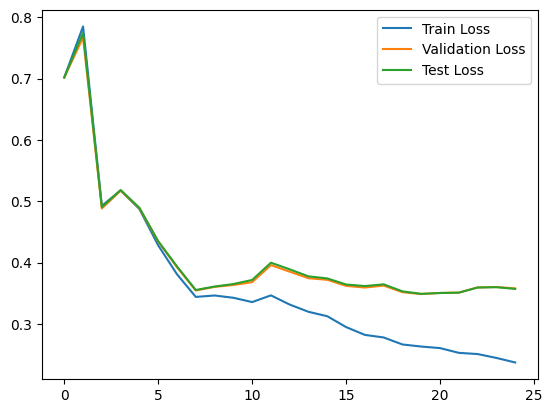

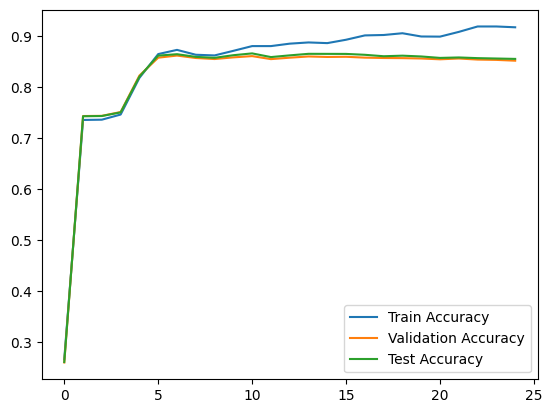

In [26]:
num_of_feat=mask.num_node_features
net=SocialGNN(num_of_feat=num_of_feat,f=16)
train_social(net,mask,epochs=25,lr=0.1)